In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

import sqlite3
from sqlalchemy import create_engine

import os.path

matplotlib.style.use('ggplot')
pd.set_option("display.max_rows",10)
plt.rcParams["figure.figsize"]  = [10,7] # width, height

In [2]:
conn = create_engine('sqlite:///../dataset/ijcai_cff_2017.db')
no_of_shops = 2000

In [3]:
all_shop_ids = np.arange(start=1, stop = (no_of_shops+1))
shops = pd.DataFrame({"shop_id":all_shop_ids})
shops.to_sql("shops", index = False, con = conn, if_exists='replace')

In [4]:
train_data_raw = pd.read_sql_query("select s.shop_id, \
(d.total_view + d.total_pay) as input_foot_traffic, date(d.ts) as ts "
                                   "from shops s LEFT OUTER JOIN train_data d ON s.shop_id = d.shop_id", 
                               con = conn)
train_data_raw

,shop_id,input_foot_traffic,ts
0,1,NaN,2015-10-10
1,1,NaN,2015-10-11
2,1,NaN,2015-10-12
3,1,NaN,2015-10-13
4,1,NaN,2015-10-14
...,...,...,...
607033,2000,148.0,2016-10-27
607034,2000,145.0,2016-10-28
607035,2000,78.0,2016-10-29
607036,2000,70.0,2016-10-30


In [5]:
print(train_data_raw.shop_id.unique().size)
print(train_data_raw.shop_id.unique())
print(np.array(train_data_raw.shop_id.unique()).shape)
print(np.mean(train_data_raw.shop_id.unique()))

2000
[   1    2    3 ..., 1998 1999 2000]
(2000,)
1000.5


In [6]:
train_data = train_data_raw.drop("ts", axis = 1)

In [7]:
#train_data = pd.read_sql_query("select shop_id, \
#(total_view + total_pay) as input_foot_traffic from train_data where ts > '2016-06-01'", 
#                               con = conn)

time_split_period = 15
time_periods_total = int(train_data.shape[0] / time_split_period) + 1

time_day_arr = np.tile(np.arange(0,15), time_periods_total)

time_period_arr = [np.full(shape=time_split_period, fill_value=i, dtype=np.int64 ) for i in range(time_periods_total)]
time_period_arr = np.concatenate(time_period_arr)

train_data["day"] = time_day_arr[0:train_data.shape[0]]
train_data["period"] = time_period_arr[0:train_data.shape[0]]
train_data['output_foot_traffic'] = train_data.input_foot_traffic.shift(-1)

train_data

,shop_id,input_foot_traffic,day,period,output_foot_traffic
0,1,NaN,0,0,NaN
1,1,NaN,1,0,NaN
2,1,NaN,2,0,NaN
3,1,NaN,3,0,NaN
4,1,NaN,4,0,NaN
...,...,...,...,...,...
607033,2000,148.0,13,40468,145.0
607034,2000,145.0,14,40468,78.0
607035,2000,78.0,0,40469,70.0
607036,2000,70.0,1,40469,183.0


In [8]:
print(train_data.shop_id.unique())
print(np.array(train_data.shop_id.unique()).shape)
print(np.mean(train_data.shop_id.unique()))

[   1    2    3 ..., 1998 1999 2000]
(2000,)
1000.5


In [9]:
train_data_p = train_data.pivot_table(index = ['shop_id', 'period'],
                       columns = 'day',
                       values = ['input_foot_traffic','output_foot_traffic']
                      )

In [10]:
train = train_data_p.dropna(how='all').reset_index().drop('period', axis=1) #
train.to_pickle("cff_15dayperiod_noNAs.pkl")

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/ipykernel/__main__.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  if __name__ == '__main__':


In [11]:
print(train.shop_id.unique())
print(np.array(train.shop_id.unique()).shape)
print(np.mean(train.shop_id.unique()))

[   1    2    3 ..., 1998 1999 2000]
(1997,)
1000.81822734


In [12]:
missing_shop_ids = all_shop_ids[np.invert(
    np.in1d(all_shop_ids, 
            train.shop_id.unique()))]

print("Missing Shop IDs: {}".format(missing_shop_ids))
        

Missing Shop IDs: [ 247  367 1752]


In [13]:
pd.read_sql_query("select * from user_view where shop_id in ({}) limit 10 "
                  .format(','
                          .join([str(i) for i in missing_shop_ids])), con = conn)

,user_id,shop_id,time_stamp


In [14]:
pd.read_sql_query("select * from user_pay where shop_id in ({}) limit 10 "
                  .format(','
                          .join([str(i) for i in missing_shop_ids])), con = conn)

,user_id,shop_id,time_stamp
0,14965213,367,2016-08-04 20:00:00
1,14965213,367,2016-09-03 19:00:00
2,15601548,367,2016-08-09 08:00:00
3,17267584,367,2016-10-19 15:00:00
4,16076418,367,2016-09-08 08:00:00
5,18177797,367,2016-09-18 16:00:00
6,8969376,367,2016-10-12 19:00:00
7,8054910,367,2016-08-31 20:00:00
8,12606064,367,2016-10-14 17:00:00
9,218697,367,2016-10-29 18:00:00


##### Checkpoint #1

# Deep Learning Approach 

There are 2 significant parts of data.
- Shop details
- Past foot traffic

As part of Deep Learning approach, we will:
- Fit a model for foot traffic
- Cluster data to generate extra features to overcome issues of Sparse data
- Fit a model to improve accuracy by utilizing Shop details

# Milestones:

- Neural Network - 2 layer, with 15 inputs and 1 output
- Neural Network - 2 layer, with 15 inputs and 15 output after filtering out stores missing data (No NAs)
- Neural Network - 2 layer, with 15 inputs and 15 outputs on Sparse / Full dataset
- Neural Network - 3 layer, with 15 inputs, 30 hidden nodes and 15 outputs
- Convolutional Network - Cluster similar stores and generate new hidden features. We will be refering to research paper [Clustering using Convolution](https://arxiv.org/abs/1511.06241 "arXiv:1511.06241v2")
- LSTM Network to better learn patterns in foot traffic
- Create a Deep Learning architecture using the learnings from above Networks.

# Milestone 1:

## Reshaping Data
In order to create a model in machine learning, we need to have inputs and ouputs. Hence, if we are trying to machine learn daily foot traffic, we will have to divide it in inputs/ouputs. Assuming, we will feed 15 days of data to predict next 15 days, we need to have a 2 matrix of [nx15]. 

In [15]:
data = pd.read_pickle("cff_15dayperiod_noNAs.pkl")
data.shape

(18720, 31)

In [16]:
print(data.shop_id.unique())
print(np.array(data.shop_id.unique()).shape)
print(np.mean(data.shop_id.unique()))

[   1    2    3 ..., 1998 1999 2000]
(1997,)
1000.81822734


## Scaling and Splitting the data into training, testing, and validation sets


In [17]:
type(data.loc[1])

pandas.core.series.Series

In [18]:
X = data.loc[:,'input_foot_traffic']
y = data.loc[:,'output_foot_traffic']
shop_id = data.loc[:,'shop_id']
X_shop_id = pd.concat([shop_id, X], axis = 1)

In [19]:
data_grouped = data.groupby("shop_id")
data_test = data_grouped.last().loc[:,'output_foot_traffic']
data_test = data_test.reset_index(col_level="day").values[:]
data_test = pd.DataFrame(data_test).rename(columns = {0:"shop_id"})
data_test

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/pandas/core/base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)


,shop_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,250.0,229.0,268.0,235.0,276.0,195.0,250.0,278.0,283.0,321.0,194.0,232.0,267.0,206.0,231.0
1,2.0,94.0,107.0,99.0,107.0,125.0,156.0,108.0,134.0,119.0,152.0,152.0,86.0,183.0,168.0,87.0
2,3.0,51.0,86.0,64.0,72.0,105.0,109.0,112.0,70.0,88.0,64.0,74.0,93.0,108.0,140.0,127.0
3,4.0,96.0,103.0,118.0,69.0,122.0,246.0,217.0,135.0,114.0,109.0,131.0,72.0,104.0,251.0,250.0
4,5.0,218.0,208.0,296.0,244.0,275.0,207.0,212.0,226.0,198.0,167.0,245.0,471.0,315.0,14.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,1996.0,76.0,67.0,79.0,72.0,87.0,89.0,92.0,105.0,107.0,110.0,106.0,109.0,104.0,104.0,84.0
1993,1997.0,321.0,307.0,277.0,225.0,94.0,120.0,292.0,305.0,298.0,289.0,224.0,126.0,114.0,300.0,346.0
1994,1998.0,354.0,658.0,531.0,544.0,557.0,625.0,539.0,329.0,359.0,589.0,610.0,588.0,667.0,645.0,448.0
1995,1999.0,162.0,469.0,355.0,330.0,301.0,307.0,303.0,364.0,477.0,458.0,303.0,311.0,298.0,303.0,320.0


In [20]:
#data_test.boxplot()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

impute_x = Imputer()
impute_y = Imputer()

scaler_x = StandardScaler()
scaler_y = StandardScaler()


def fetch_data(input_nodes_num, output_nodes_num):
    
    X_ = X.values
    y_ = y.iloc[:,0:output_nodes_num].values
    
    X_ = impute_x.fit_transform(X_)
    y_ = impute_y.fit_transform(y_)
    
    X_norm = scaler_x.fit_transform(X_)
    y_norm = scaler_y.fit_transform(y_)
    
    #X_norm = norm[:,0:input_nodes_num]
    #y_norm = norm[:,input_nodes_num:]
   
    X_train, X_valid, y_train, y_valid = train_test_split(
    X_norm, y_norm , test_size=0.45, random_state=42)
    
    X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid , test_size=0.15, random_state=42)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

## Visualize 15 days data

Let's see if there is any observable pattern for 15 days of data between stores 

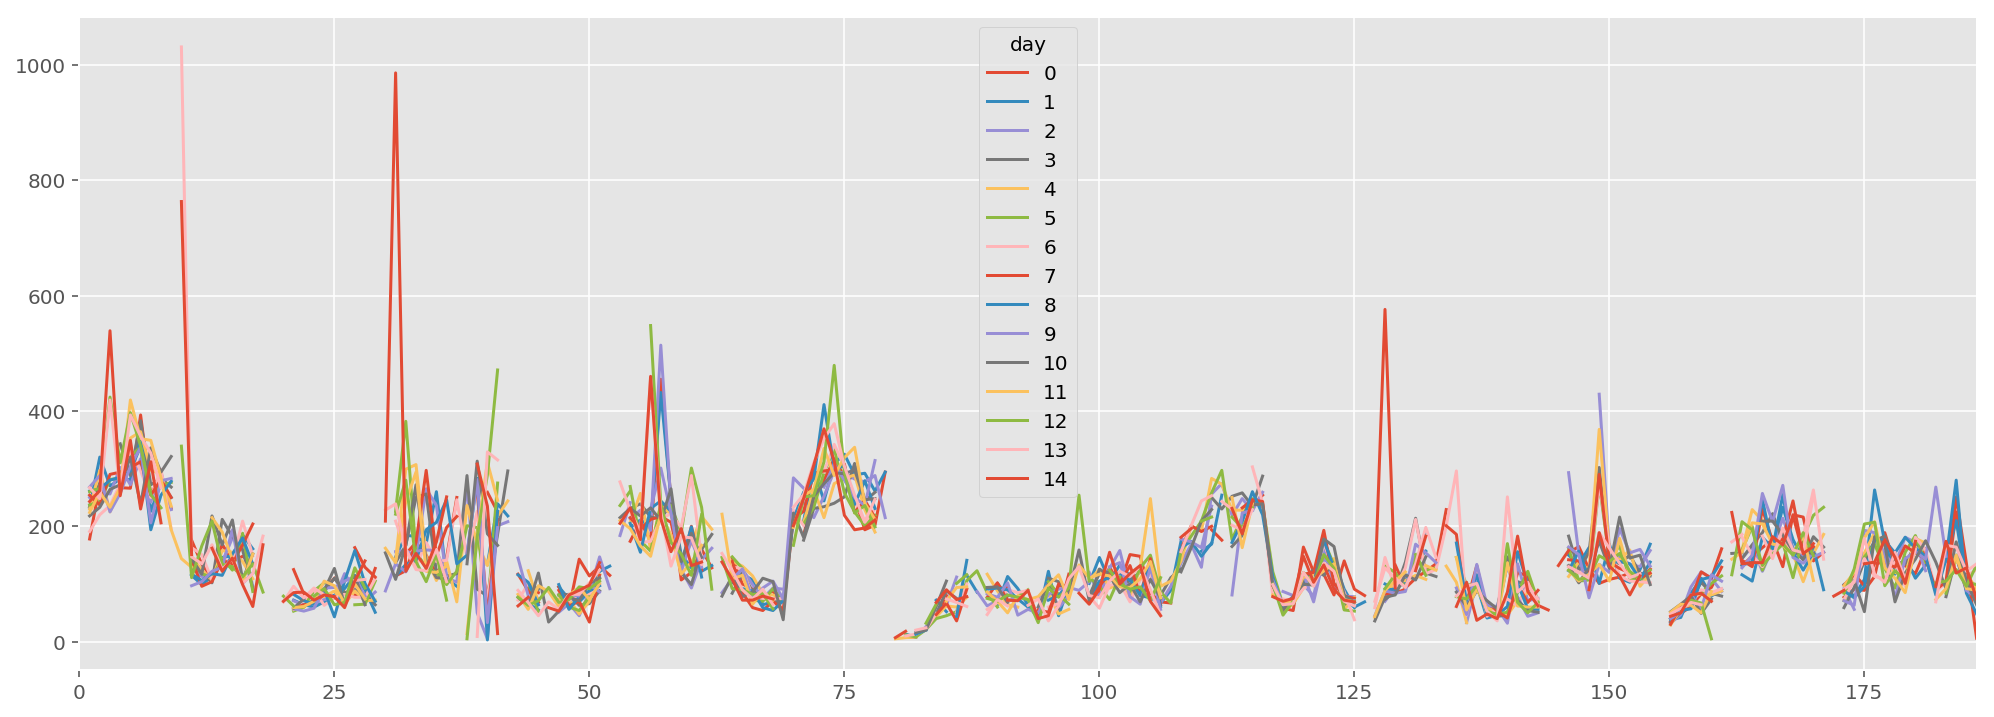

In [22]:
train_count = int(X.shape[0] * 0.01)

X_train = X[:train_count]

X_train.plot(figsize=[17,6])

## Network Model

<img  src="ErrorFunction_ijcai_2017.png"/>

In [23]:
import tensorflow as tf
sess = tf.InteractiveSession()
#tf.reset_default_graph()

input_nodes_num = 15
output_nodes_num = 15
hidden_layer_num = 2

beta = 0.01

tf_x = tf.placeholder(tf.float32, [None, input_nodes_num],name='Inputs')
tf_y_ = tf.placeholder(tf.float32, [None, output_nodes_num], name='ActualOutput')

tf_W = tf.Variable(tf.truncated_normal([input_nodes_num, output_nodes_num], stddev = 0.001),name='Weights')
tf_b = tf.Variable(tf.constant(value = 1., shape = [output_nodes_num]),name='bias')

tf_y_h = tf_x
for i in range(hidden_layer_num):
    tf_W_h = tf.Variable(tf.truncated_normal([input_nodes_num, input_nodes_num], stddev = 0.001),name='Weights_{}'.format(i))
    tf_b_h = tf.Variable(tf.constant(value = 1., shape = [output_nodes_num]),name='bias_{}'.format(i))
    tf_y_h = tf.nn.relu(tf.add(tf.matmul(tf_x, tf_W_h), tf_b_h))

tf_y = tf.add(tf.matmul(tf_y_h, tf_W), tf_b)

sq_diff = tf.reduce_mean(tf.squared_difference( tf_y_ , tf_y), name = "Squared_Difference")
#sq_diff = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = tf_y_ , labels = tf_y))

sq_diff_test = tf.reduce_mean(
    tf.abs(
        tf.divide(
            tf.subtract(tf_y, tf_y_),
            tf.add(tf_y, tf_y_)
        )
    )
)

sq_diff_test_modified = tf.reduce_mean(
    tf.abs(
            tf.subtract(tf_y, tf_y_)
    )
)

regularizer = tf.nn.l2_loss(tf_W)
sq_diff = tf.reduce_mean(sq_diff + beta * regularizer)

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(sq_diff)
X_train, X_valid, X_test, y_train, y_valid, y_test = fetch_data(input_nodes_num,output_nodes_num )

In [24]:
X_train.shape

(10296, 15)

In [25]:
y_train.shape

(10296, 15)

## Training the Network

- Network will be trained using Stochastic Gradient Descent.

Train 0.6179344654083252, Valid - 0.5610772371292114, Comp: 1.440513253211975, MAD: 0.30035585165023804
Train 0.04065193980932236, Valid - 0.04886598885059357, Comp: 0.4184177815914154, MAD: 0.07775965332984924
Train 0.033262237906455994, Valid - 0.03961683064699173, Comp: 0.47266238927841187, MAD: 0.06546023488044739
Train 0.03331420570611954, Valid - 0.03872815892100334, Comp: 0.6152282357215881, MAD: 0.06966251134872437
Train 0.03361529856920242, Valid - 0.03849192336201668, Comp: 0.49161452054977417, MAD: 0.07260503619909286
Train 0.032398976385593414, Valid - 0.037291113287210464, Comp: 0.414693683385849, MAD: 0.06690747290849686
Train 0.03149598836898804, Valid - 0.03660878166556358, Comp: 0.4512390196323395, MAD: 0.06470425426959991


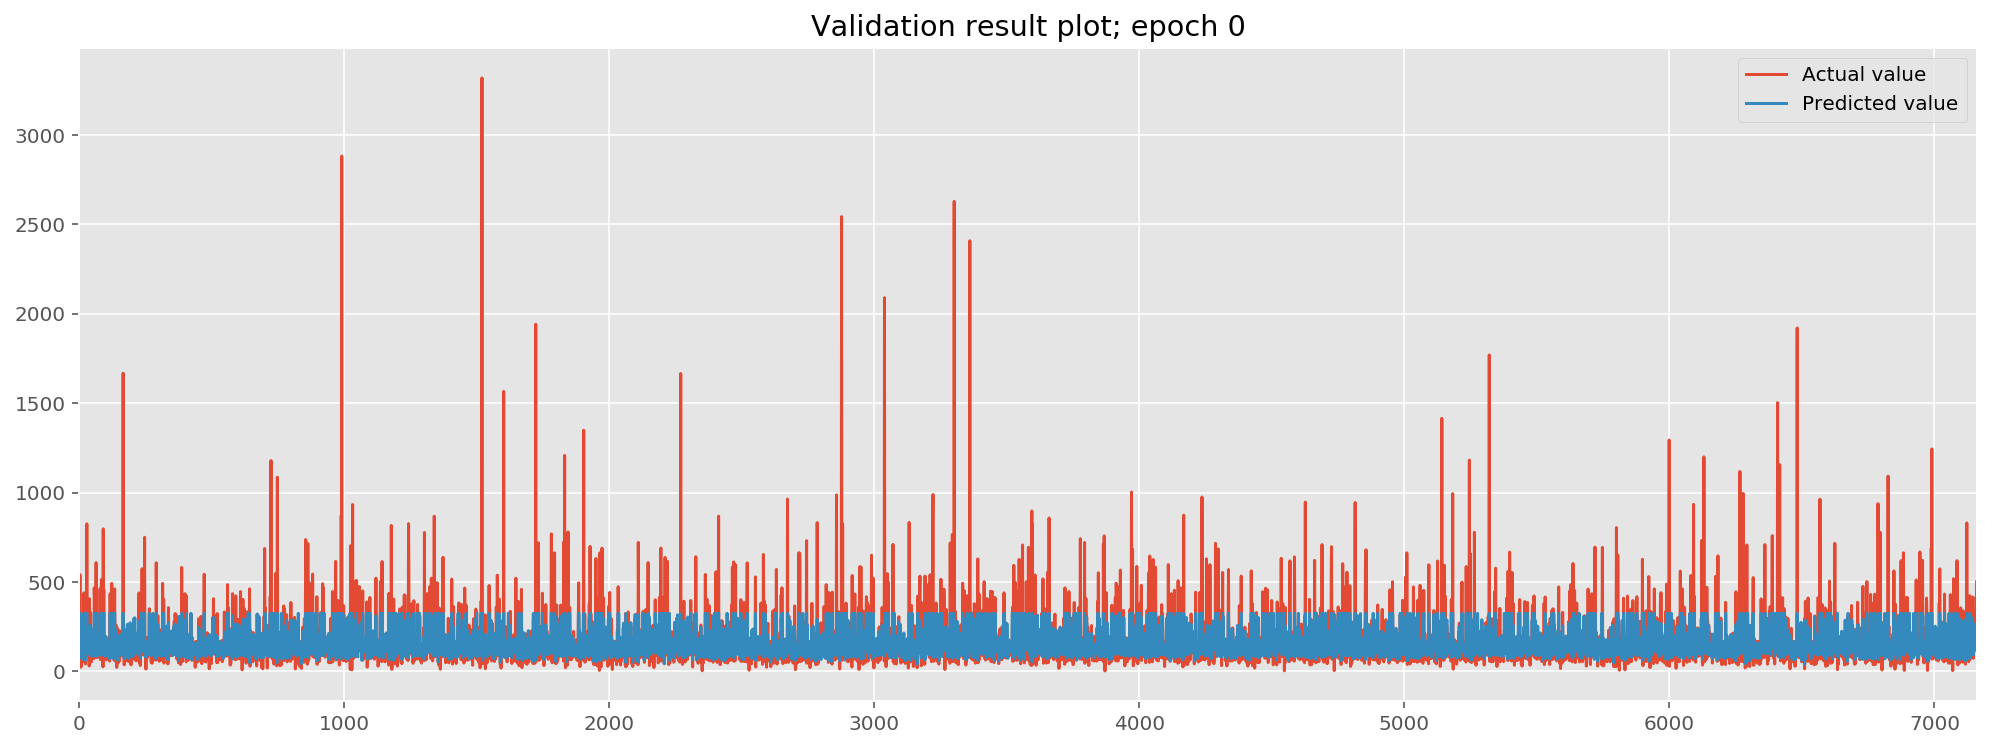

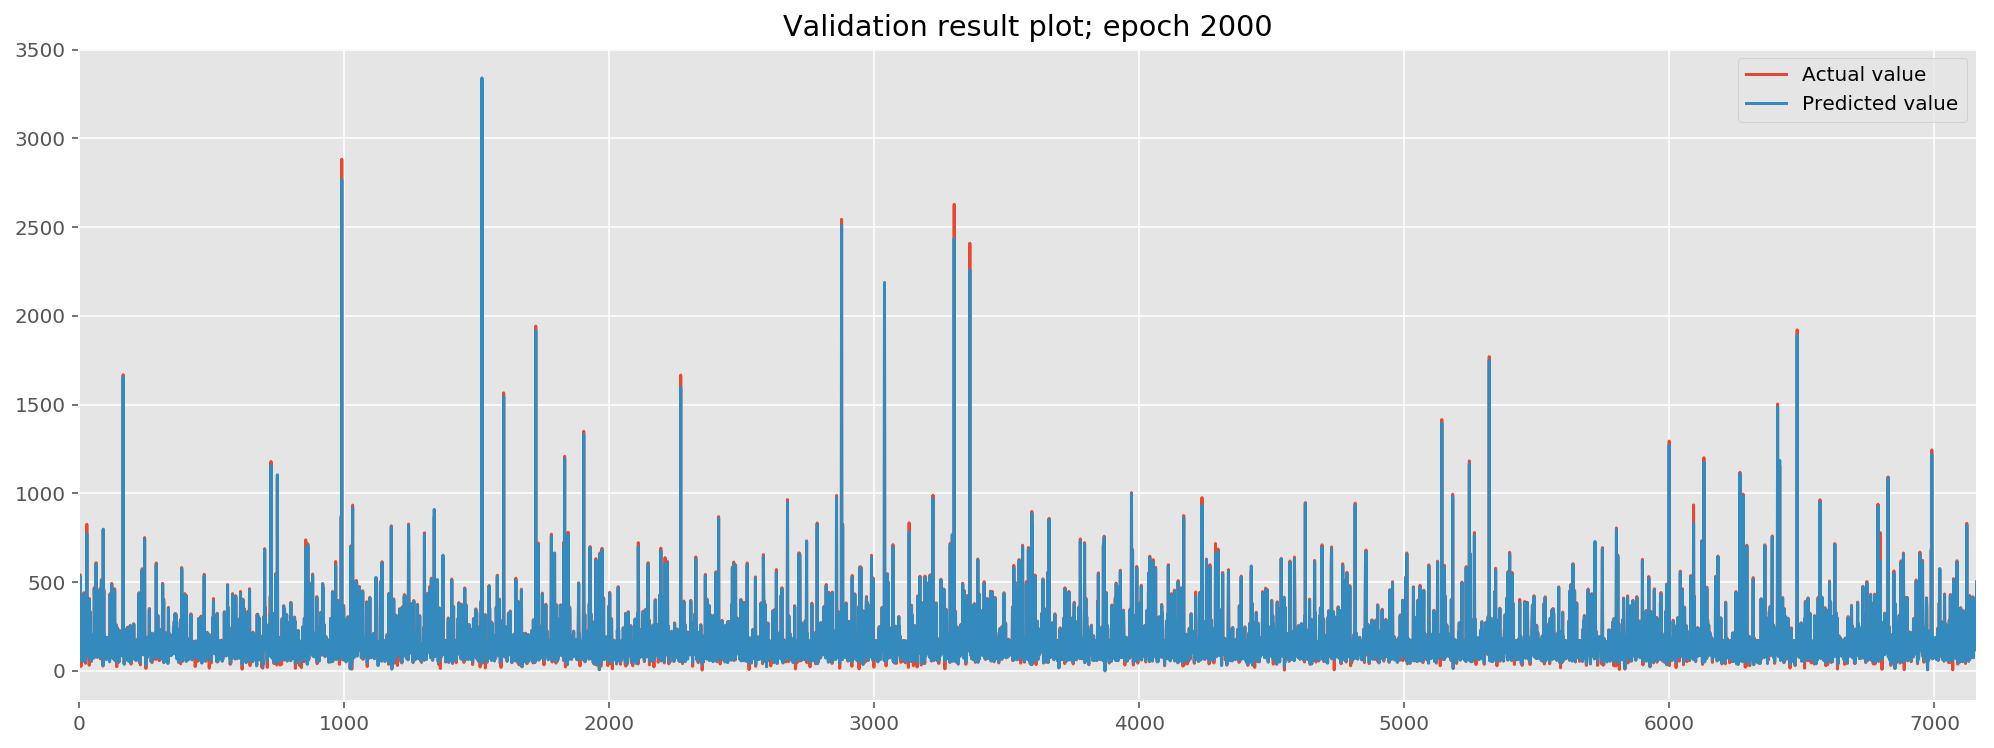

In [26]:
#tf.initialize_all_variables().run()
tf.global_variables_initializer().run(session=sess)

answer_valid_first = pd.DataFrame()
answer_valid_last = pd.DataFrame()

step = 200
losses = {'train':[], 'validation(MSE)':[], "validation(Competition)":[]}


for i in range(3001):
    #index = np.random.randint(size=200,low = 0, high = X_train.shape[0])
    for index in range(0, X_train.shape[0], step):
        batch_xs = X_train[index:(index+step),:]
        batch_ys = y_train[index:(index+step),:]

        sess.run(train_step, feed_dict={tf_x: batch_xs, tf_y_:batch_ys })
    
    #Get training predicted values and loss
    tr_y = tf_y.eval(feed_dict={tf_x: X_train})
    tr_sq_diff = sq_diff.eval(feed_dict={tf_x: X_train, tf_y_:y_train})
    
    #Get validation predicted values and loss
    tv_y = tf_y.eval(feed_dict={tf_x: X_valid})
    vd_sq_diff = sq_diff.eval(feed_dict={tf_x: X_valid, tf_y_:y_valid})
    
    cvd_sq_diff = sq_diff_test.eval(feed_dict={tf_x: X_valid, tf_y_:y_valid})
    mvd_sq_diff = sq_diff_test_modified.eval(feed_dict={tf_x: X_valid, tf_y_:y_valid})
    
    losses['train'].append(tr_sq_diff)
    losses['validation(MSE)'].append(vd_sq_diff)
    losses['validation(Competition)'].append(cvd_sq_diff)  
    
    if i % 500 == 0:
        print ("Train {}, Valid - {}, Comp: {}, MAD: {}"
               .format(tr_sq_diff, vd_sq_diff, cvd_sq_diff, mvd_sq_diff))
        
    if i % 2000 == 0:
        
        tr_y_rescaled = scaler_y.inverse_transform(tr_y)
        y_train_rescaled = scaler_y.inverse_transform(y_train)
        tv_y_rescaled = scaler_y.inverse_transform(tv_y)
        y_valid_rescaled = scaler_y.inverse_transform(y_valid)
        
        # Comparing only 1st prediction
        answer_train = pd.DataFrame({"Predicted value":tr_y_rescaled[:,0], "Actual value":y_train_rescaled[:,0]})
        #answer_train.plot(title='Training result plot; epoch {}'.format(i), figsize=[17,6])

        global answer_valid_first
        global answer_valid_last
        answer_valid_first = pd.DataFrame({"Predicted value":tv_y_rescaled[:,0], "Actual value":y_valid_rescaled[:,0]})
        answer_valid_last = pd.DataFrame({"Predicted value":tv_y_rescaled[:,-1], "Actual value":y_valid_rescaled[:,-1]})
        
        answer_valid_first.plot(title = 'Validation result plot; epoch {}'.format(i), figsize=[17,6])

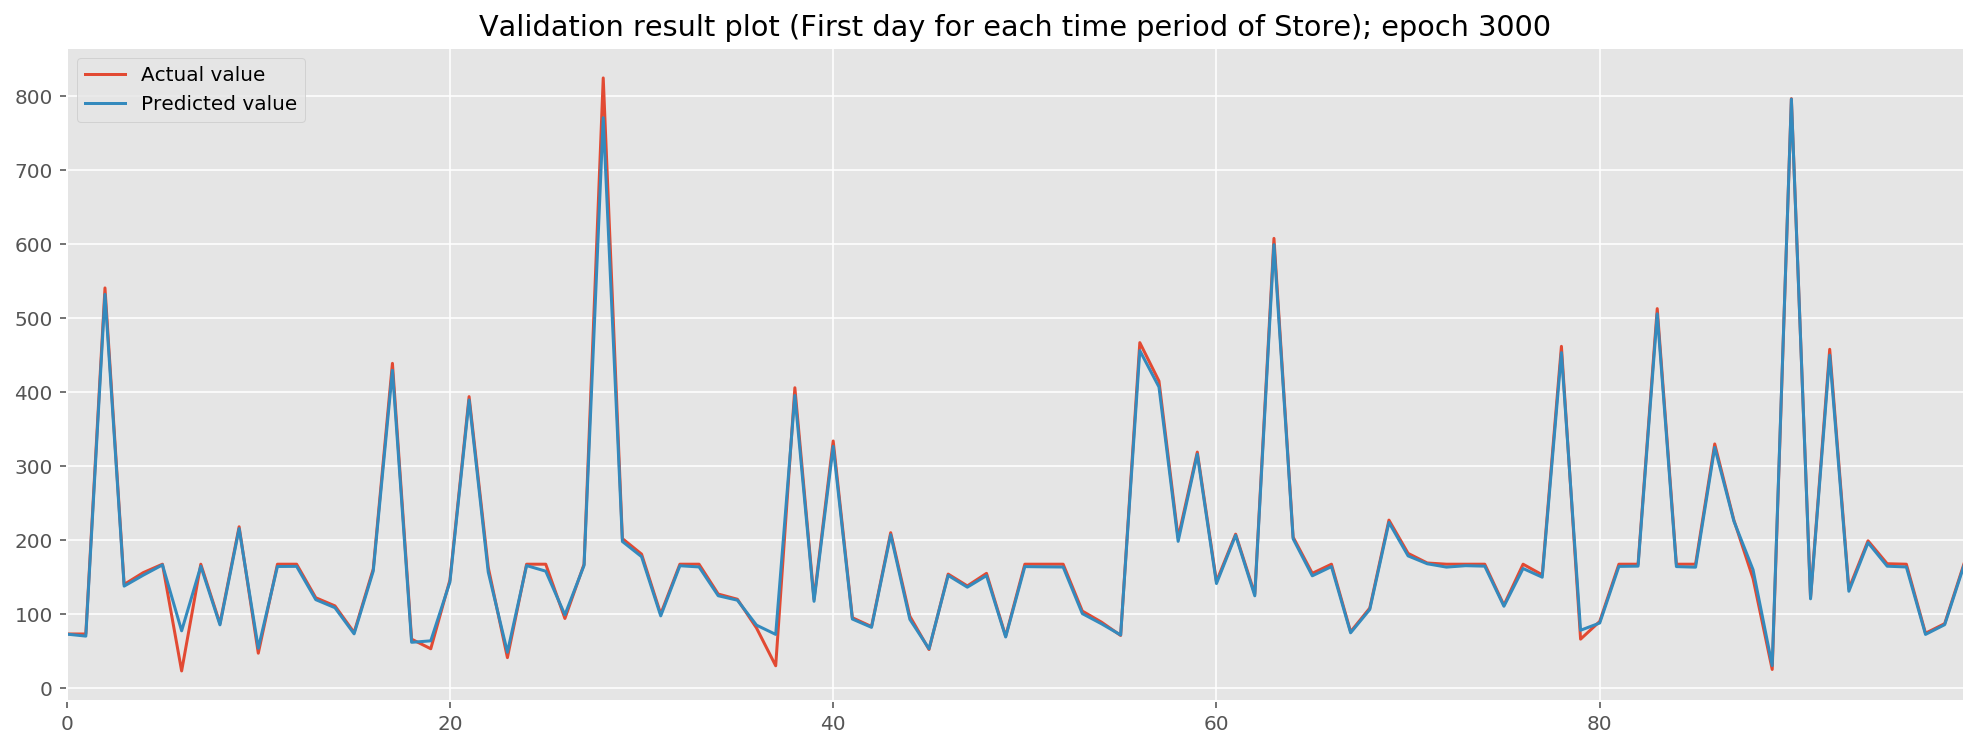

In [27]:
answer_valid_first[:100].plot(title = 'Validation result plot (First day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

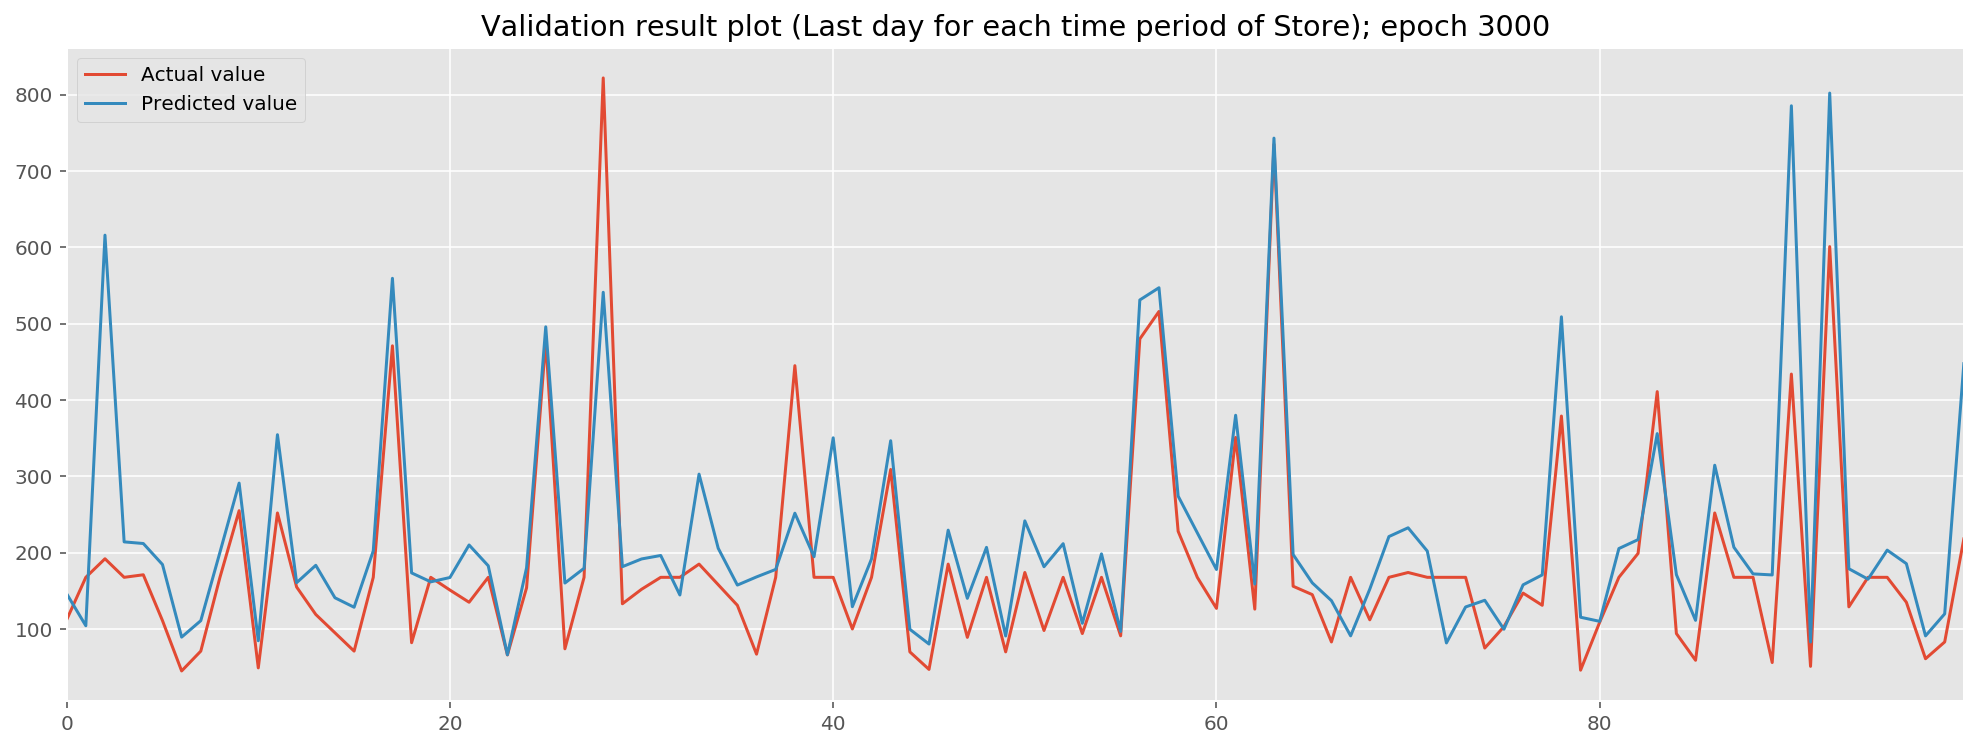

In [28]:
answer_valid_last[:100].plot(title = 'Validation result plot (Last day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

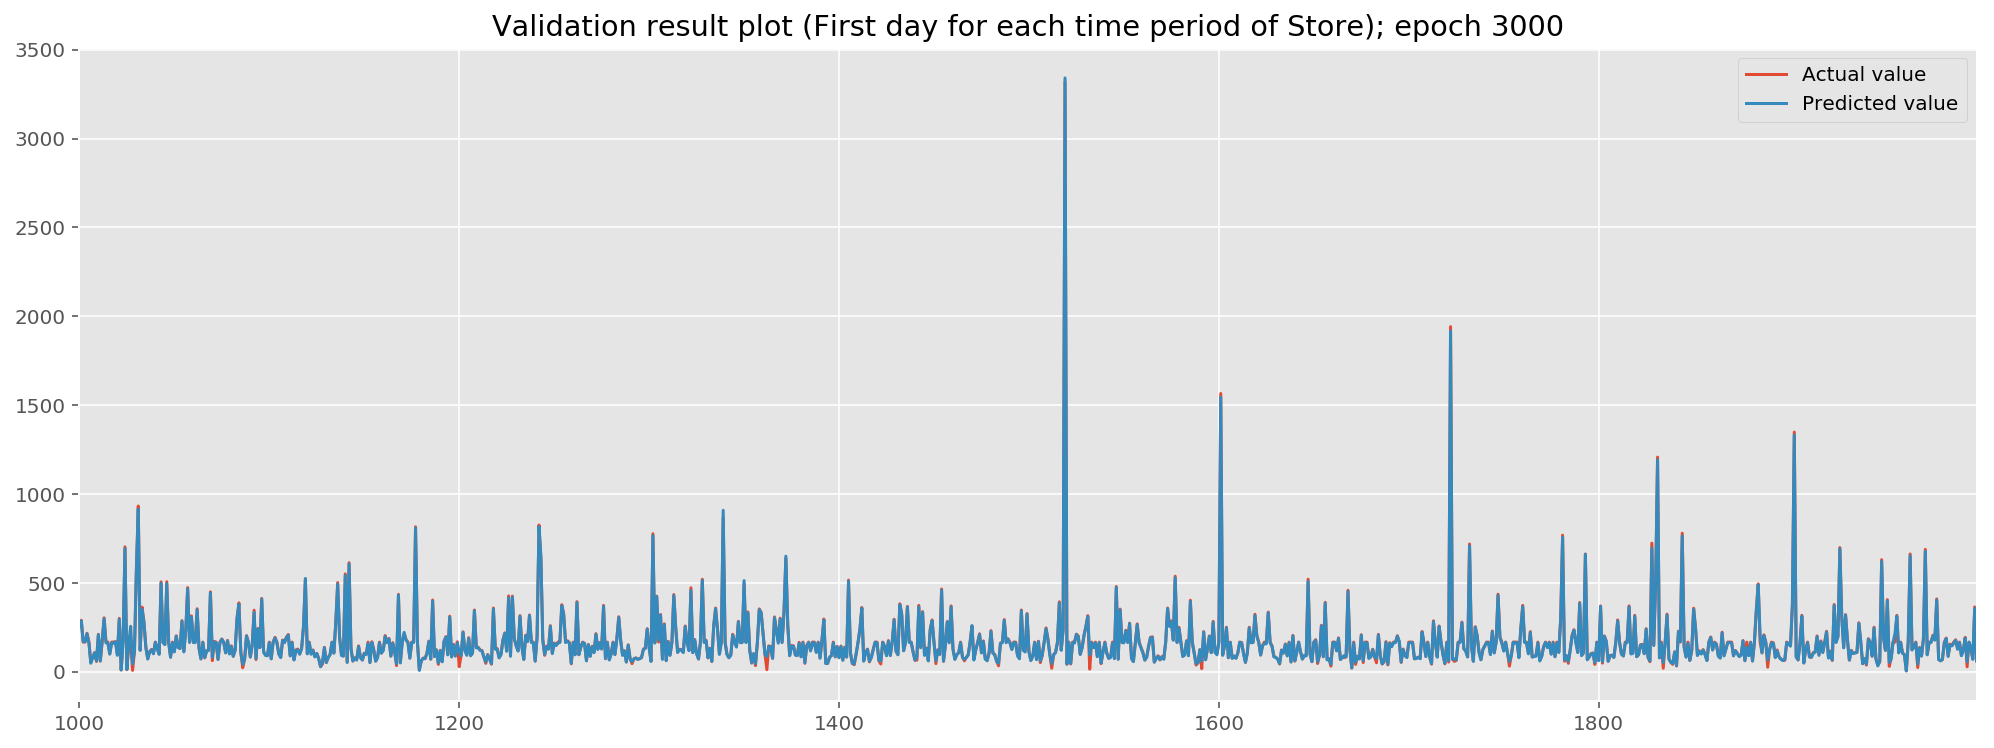

In [29]:
answer_valid_first[1000:2000].plot(title = 'Validation result plot (First day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

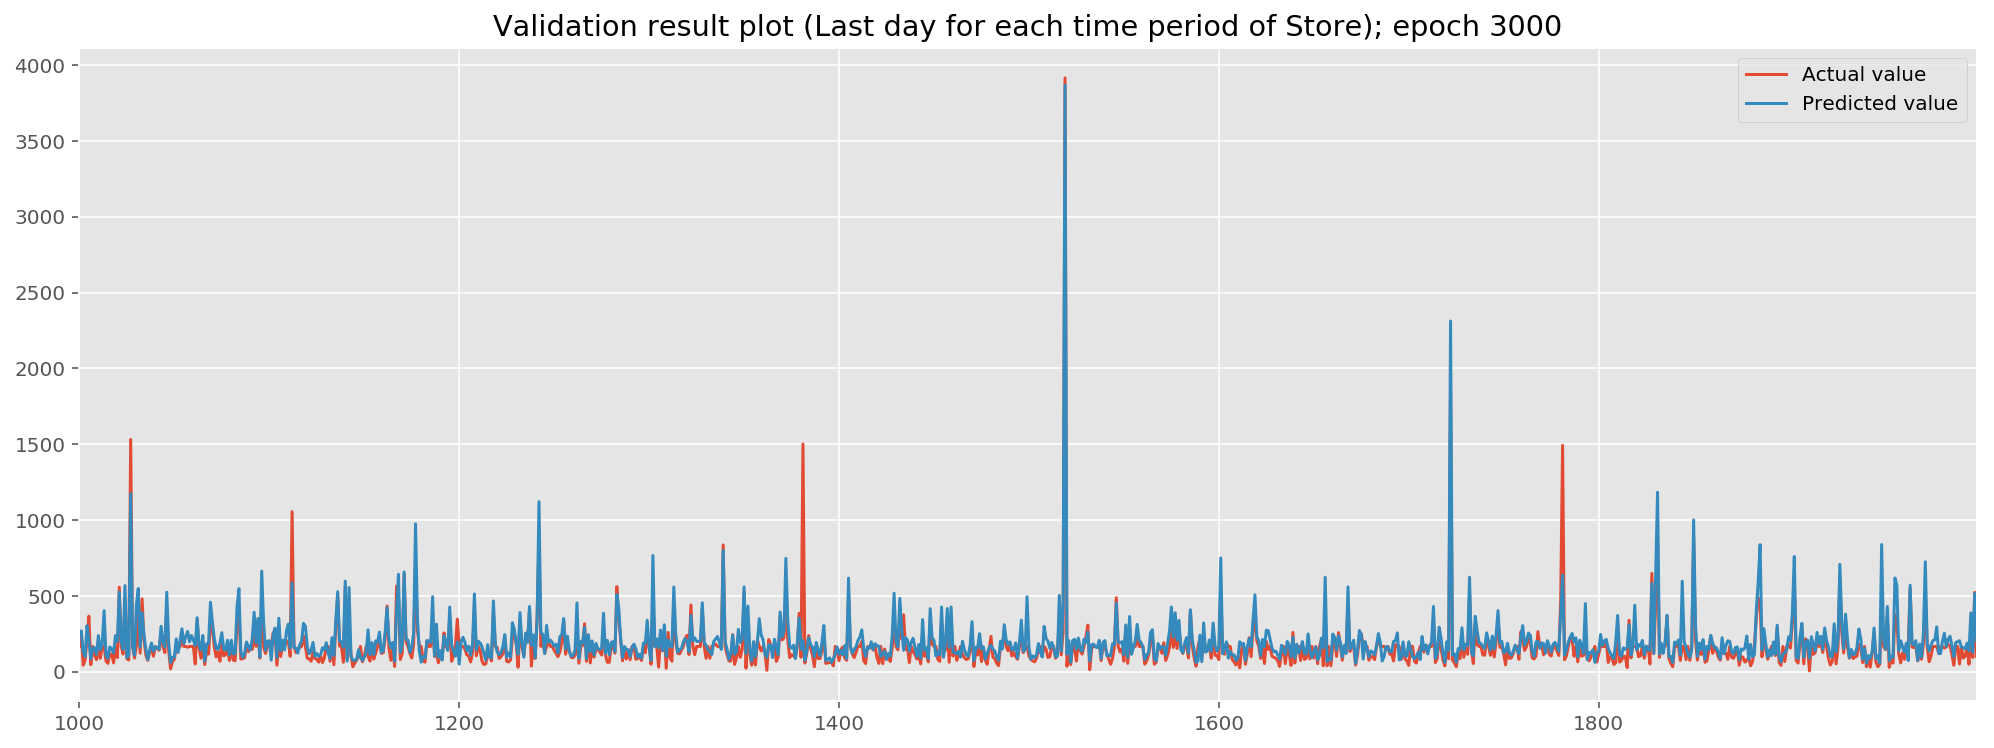

In [30]:
answer_valid_last[1000:2000].plot(title = 'Validation result plot (Last day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

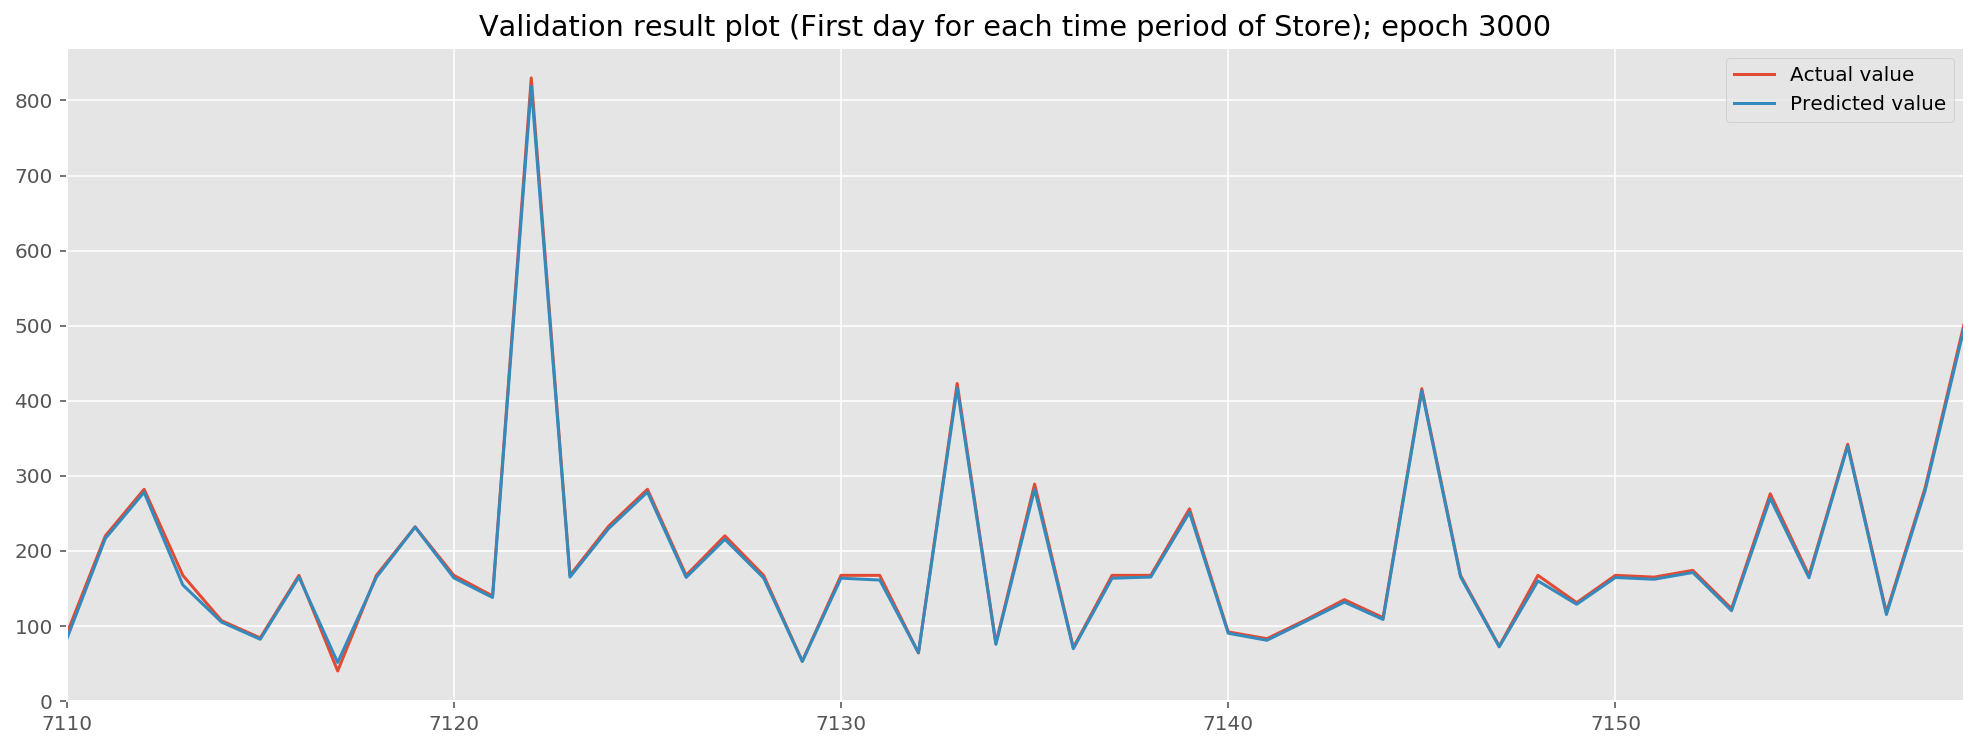

In [31]:
answer_valid_first[-50:].plot(title = 'Validation result plot (First day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

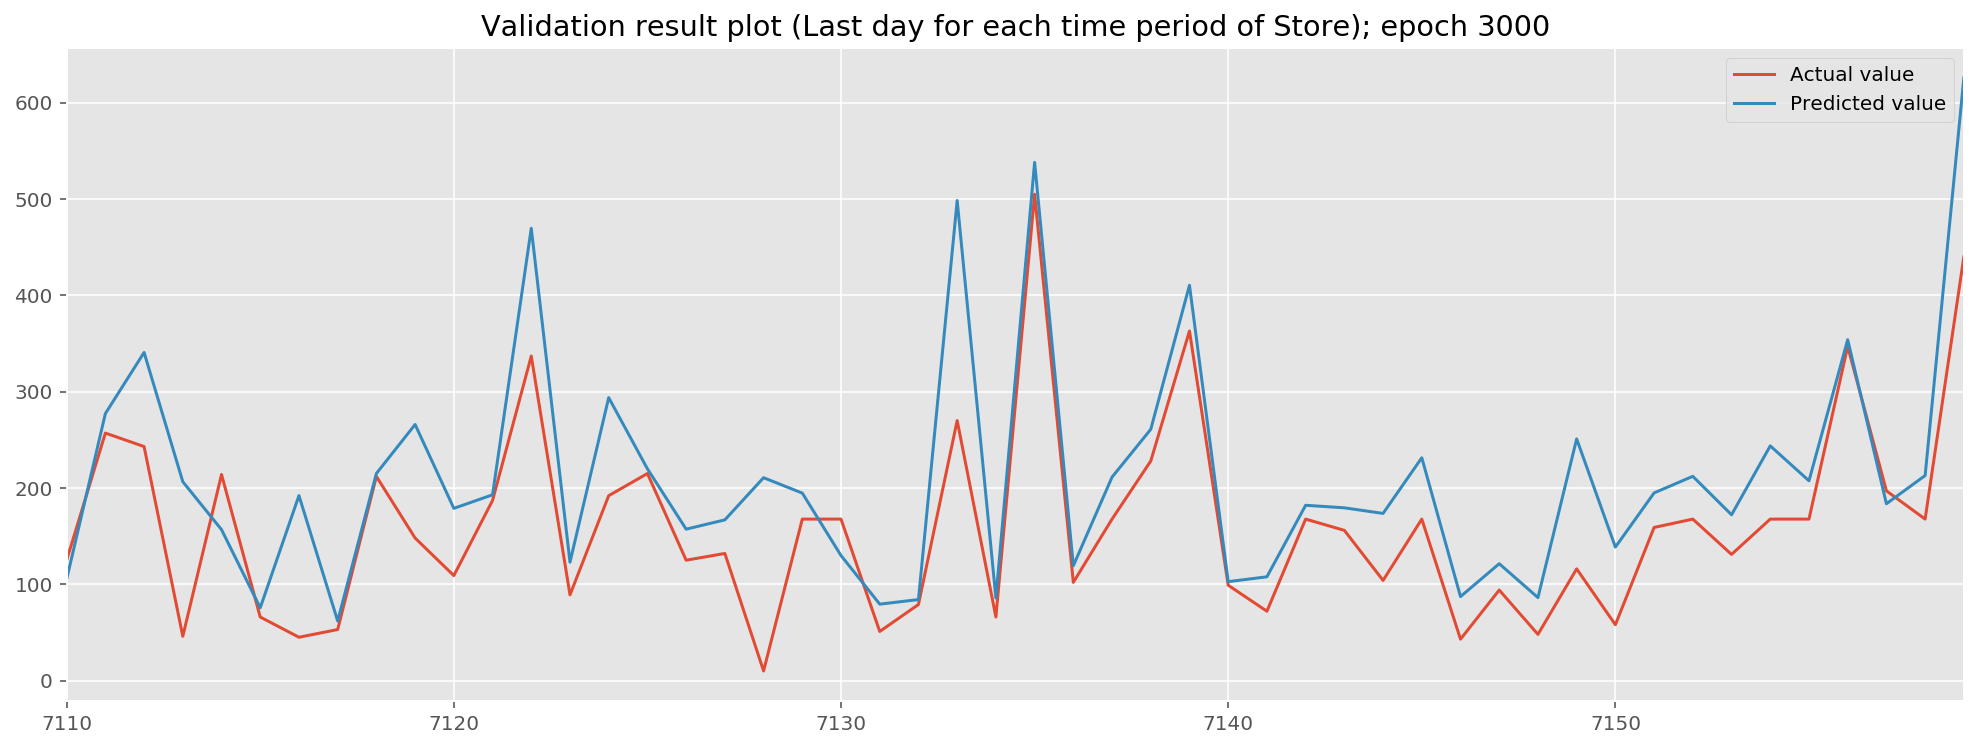

In [32]:
answer_valid_last[-50:].plot(title = 'Validation result plot (Last day for each time period of Store); epoch {}'.format(i), figsize=[17,6])

First day prediction

In [33]:
answer_valid_first[-50:] # Last Day prediction for last 50 stores

,Actual value,Predicted value
7110,89.000000,82.160095
7111,220.000000,216.500519
7112,282.000000,277.965485
7113,167.366799,154.607269
7114,107.000000,105.101059
...,...,...
7155,167.366799,164.124069
7156,342.000000,339.542603
7157,118.000000,115.149521
7158,284.000000,280.066803


Last day prediction

In [34]:
answer_valid_last[-50:] # First Day prediction for last 50 stores

,Actual value,Predicted value
7110,125.000000,105.214180
7111,257.000000,277.233368
7112,243.000000,340.710846
7113,46.000000,206.483185
7114,214.000000,156.739166
...,...,...
7155,167.671276,207.450470
7156,347.000000,353.963013
7157,197.000000,183.595764
7158,167.671276,212.910400


### Plotting Loss

(-4.0032905440777542, 2)

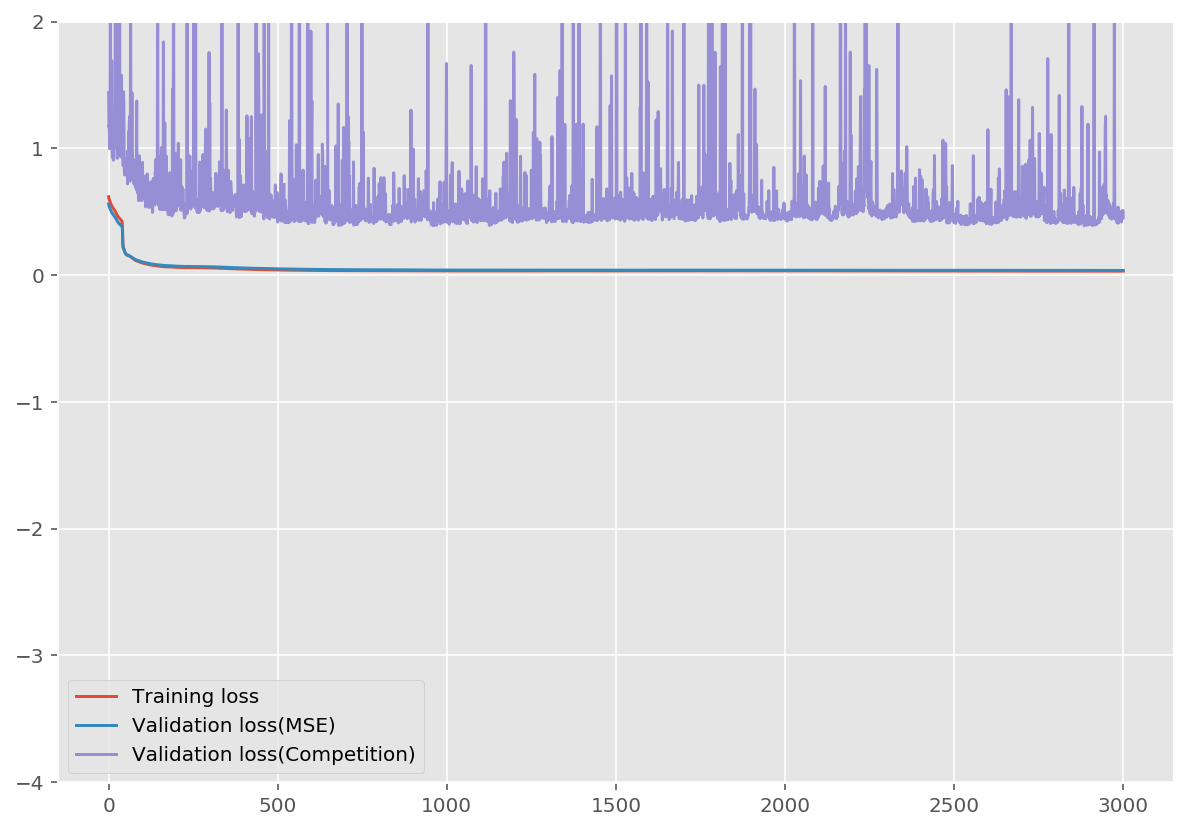

In [39]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation(MSE)'], label='Validation loss(MSE)')
plt.plot(losses['validation(Competition)'], label='Validation loss(Competition)')

plt.legend()
plt.ylim(ymax=2)

In [36]:
print("Loss on Test data (using Mean Square Difference) {}".format(sq_diff.eval(feed_dict={tf_x: X_test, tf_y_:y_test})))
print("Loss on Test data (using Formula provided by competition) {}".format(sq_diff_test.eval(feed_dict={tf_x: X_test, tf_y_:y_test})))
print("Loss on Test data (using Mean Absolute Difference) {}".format(sq_diff_test_modified.eval(feed_dict={tf_x: X_test, tf_y_:y_test})))


Loss on Test data (using Mean Square Difference) 0.036729149520397186
Loss on Test data (using Formula provided by competition) 0.4123184084892273
Loss on Test data (using Mean Absolute Difference) 0.0615248940885067


Data to submit to competition

In [37]:
count = 1
data_test.iloc[:,1:] = data_test.iloc[:,1:].apply(lambda X_test: tf_y.eval(feed_dict={tf_x: X_test.values.reshape(1,-1)}).ravel(), axis = 1) # 
data_test

,shop_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,232.978577,268.776764,244.045288,258.571014,190.022675,269.645569,285.884033,285.634125,314.680176,207.714996,232.081360,252.798447,219.211517,221.911667,297.071350
1,2.0,105.120651,99.940384,106.290146,126.032387,148.852066,119.774269,131.803757,126.830429,146.450409,154.786911,84.331268,175.233459,169.499481,85.289612,120.343964
2,3.0,89.552025,65.047089,86.669853,86.409355,105.688545,108.468658,79.179787,86.224236,66.962074,75.731155,95.883347,98.878365,139.215744,114.758080,111.817963
3,4.0,118.285851,108.310730,92.901169,93.141579,233.330322,210.760956,144.445145,106.458580,129.334457,128.461441,78.283325,91.074654,244.551392,225.835190,155.501709
4,5.0,213.819000,297.331451,245.134476,259.892548,196.144516,225.166550,237.254318,197.888763,165.714905,272.269592,467.391571,300.174866,51.721130,213.482224,275.054962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,1996.0,68.049057,79.517784,75.521812,80.157021,86.945061,98.978561,108.031723,108.204109,107.300690,110.689735,108.852455,98.964935,109.249275,80.758118,110.779594
1993,1997.0,304.112488,276.826965,223.382645,95.116249,103.868584,311.000305,299.919250,311.328461,277.690094,229.613037,121.348534,100.360405,303.284485,342.776184,340.957947
1994,1998.0,627.624084,561.335938,566.866150,542.874634,592.495911,550.764160,338.682434,412.434357,539.496521,615.192688,578.454346,618.864014,640.675171,425.218201,543.984619
1995,1999.0,468.601227,358.198181,343.474548,276.087158,297.047791,330.579498,374.887390,483.773132,446.270081,321.250488,310.252869,277.270020,319.553802,307.832916,460.594574
